In [59]:
from scipy.io import loadmat
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from ROC import get_DIs


%matplotlib inline

In [2]:
filelist = ["calcium_data/140708B_140811a_result", 
            "calcium_data/140909C_141112a_result", 
            "calcium_data/141006C_141121a_result",
            "calcium_data/150109A_150302a_result", 
            "calcium_data/151122A_160202a_result", 
            "calcium_data/151122B_160207a_result", 
            "calcium_data/160209A_160430a_result", 
            "calcium_data/160209B_160428a_result"]

In [87]:
def get_SI(PF, NF):
    return -(np.sqrt(np.sum((PF - NF)**2)) - np.sqrt(np.sum(PF**2)))/np.sqrt(np.sum(PF**2))

In [151]:
filename = filelist[0]
f = h5py.File(filename+".hdf5", "r")

In [152]:
meta = f['meta']
stims = np.unique(meta[:,1])[1:]

#compute hits/misses
NF = []
for stim in stims:
    trials_mask = meta[:,1]==stim
    rate = np.sum(meta[trials_mask,2]==1)/np.sum(meta[trials_mask,2].shape[0]) #hits over misses
    NF.append(rate)

In [153]:
n = 5
n_dendrites = h5py.File(filename+".hdf5", "r")['data'].shape[1]

DI_stim = np.zeros((n_dendrites, stims.shape[0]))

#get highest average DIs
for k, stim in enumerate(stims):
    DI_stim[:,k] = get_DIs(filename, stim)
    
avs = np.mean(DI_stim, axis=1)
avs_inds = np.argsort(avs)

inds_pos = avs_inds[::-1][:n]
inds_neg = avs_inds[:n]

SIs_pos = []
SIs_neg = []
for i in range(n):
    PF = DI_stim[inds_pos[i]]
    SI_pos = get_SI(PF, NF)
    
    PF = DI_stim[inds_neg[i]]
    SI_neg = get_SI(PF, NF)
    
    SIs_pos.append(SI_pos)
    SIs_neg.append(SI_neg)
    
p_ind = np.argmax(SIs_pos)
n_ind = np.argmax(SIs_neg)

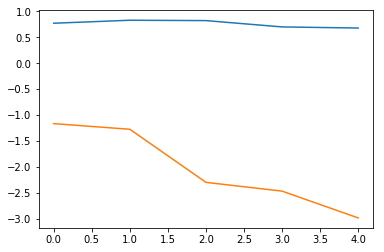

In [154]:
plt.plot(SIs_pos)
plt.plot(SIs_neg)

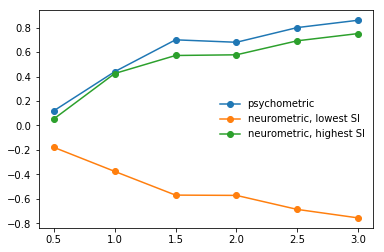

In [155]:
plt.errorbar(stims, NF, fmt='-o', label='psychometric')
plt.errorbar(stims, DI_stim[inds_neg[n_ind]], fmt='-o', label='neurometric, lowest SI')
plt.errorbar(stims, DI_stim[inds_pos[p_ind]], fmt='-o', label='neurometric, highest SI')
plt.legend(frameon=False)
#plt.errorbar(stims, neg[0])
#plt.ylim(0,1)

In [92]:
pos[0]

array([-4.37073201, -5.3945008 , -4.8757282 , -3.60869915, -3.81857458,
       -4.07236006])